# Basic Explorative Data Analysis
For the following conclusions we do assume that the present data set is complete (i.e., there has been no deliberate removal of data for the given time frame).

In [11]:
# Import necessary libraries
import numpy as np
import pandas as pd
import itertools

import itertools
import networkx as nx
from networkx.algorithms import clique
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [12]:
# Import data
data = pd.read_csv("data/races.csv", sep=";")
data["race_created"] = pd.to_datetime(data["race_created"], dayfirst=True)

In [13]:
# Parameter
title_fontsize = 25
axis_fontsize = 20
legend_size = 20
tick_label_fontsize = 15

## 1 Time
We first invesetigate the data with respect to time.
### 1.1 Races
First we look at the number of races/games played vs time. This gives us a first feeling on how the data is distributed in time.

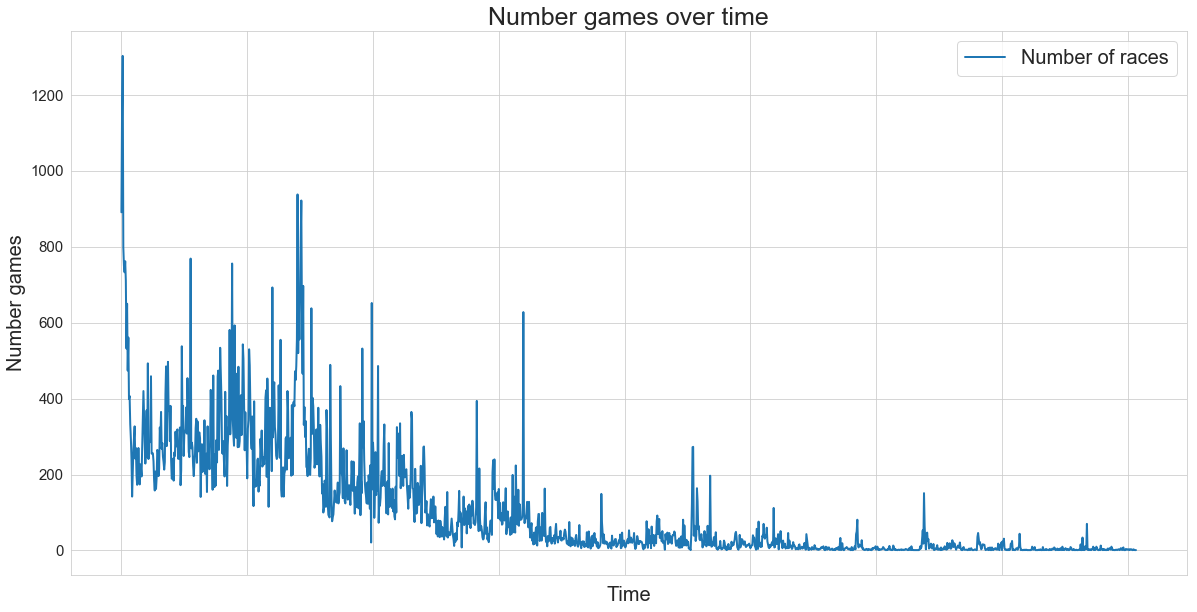

In [14]:
df_time = pd.DataFrame(data.groupby("race_created").count()).reset_index()
df_time.rename(columns={"id": "count"}, inplace=True)
df_time = df_time[["race_created", "count"]]

df_time["month"] = df_time["race_created"].dt.strftime("%b")
df_time["year"] = df_time["race_created"].dt.strftime("%y")
df_time["race_date"] = df_time["month"] +  " " + df_time["year"].astype("str")

fig, ax = plt.subplots(figsize=(20, 10))

df_time[["race_date","count"]].set_index("race_date").plot(ax=ax, lw=2, label="Number of races")
plt.title("Number games over time", fontsize=title_fontsize)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Number games", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(labels = ["Number of races"], prop={"size": legend_size})

plt.show()

At the start of the time series we see a lot of activity by the players. This period of high popularity ranges from March 2012 until Summer 2013. This period is followed by a sharp peak of driven races at the end of 2013. Afterwards, the data shows two smaller peaks in summer of 2014 and 2015, respectively. However, there are only a fraction of the driven races during the time of high popularity of the game.

### 1.2 Players
In addition to the time series of driven races we can take a look at the number of players. As expected we find a close relationship between the two curves.

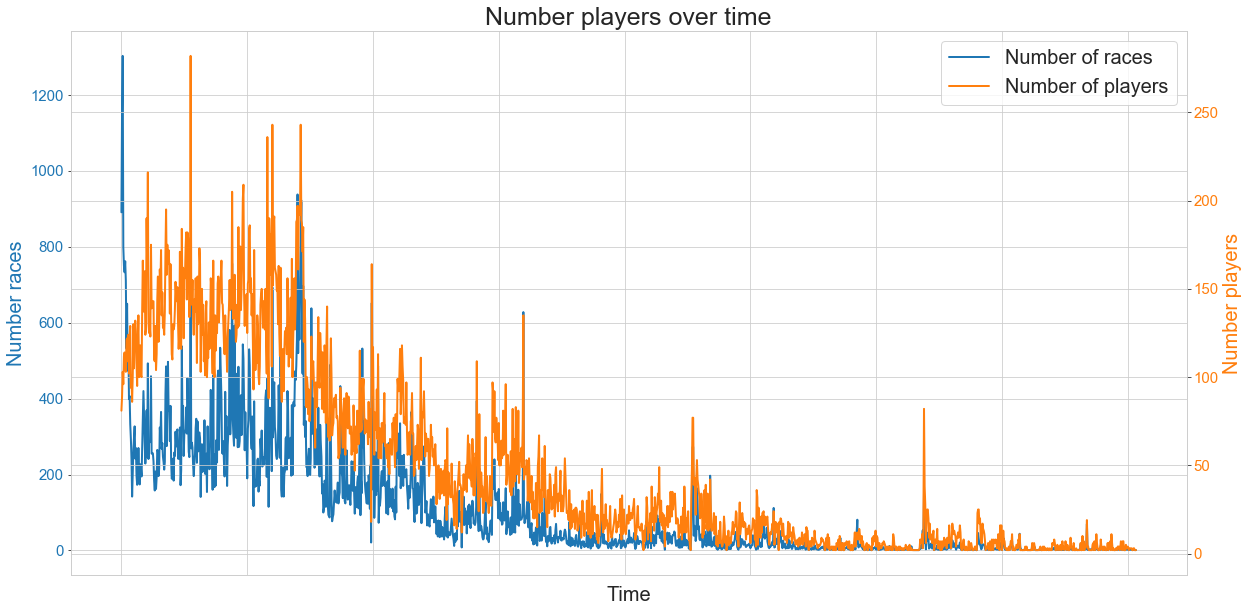

In [15]:
df_time["number_unique_players"] = data.groupby("race_created")["challenger", "opponent"].apply(lambda x: len(list(np.unique(x)))).values

fig, ax = plt.subplots(figsize=(20, 10))

race_plot = df_time[["race_date","count"]].set_index("race_date").plot(ax=ax, lw=2, label="Number of races", legend=False)
plt.title("Number players over time", fontsize=title_fontsize)
plt.xlabel("Time", fontsize=axis_fontsize)
ax.set_ylabel("Number races", fontsize=axis_fontsize, color="tab:blue")
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.tick_params(axis="y", labelcolor="tab:blue")

ax1 = ax.twinx()
player_plot = df_time[["race_date","number_unique_players"]].set_index("race_date").plot(ax=ax1, lw=2, label="Number of players", color="tab:orange", legend=False)
ax1.set_ylabel("Number players", fontsize=axis_fontsize, color="tab:orange")
ax1.tick_params(axis="y", which="major", labelsize=tick_label_fontsize, labelcolor="tab:orange")

handle_race, _ = ax.get_legend_handles_labels()
handle_player, _ = ax1.get_legend_handles_labels()
ax1.legend(handle_race + handle_player, ["Number of races", "Number of players"], prop={"size": legend_size})

plt.show()

Both the number of races and number of players have a similar shape. Yet, we find in general that the number of players decays slower than the number of races. This indicates that even after the initial hype of the game there were some continued activity by players. Still, because of the overall smaller community, less amounts of races were driven.

### 1.3 Weekly distribution of races
For the weekly distribution we would expect a higher amount of races driven on the weekend, compared to week days. While we indeed find the highest amount of races on Sunday, both Friday and Saturday show the lowest amount of all days. This is quite unexpected. TODO: A possible speculation might be that the game is a mobile game?? Check with game activity...

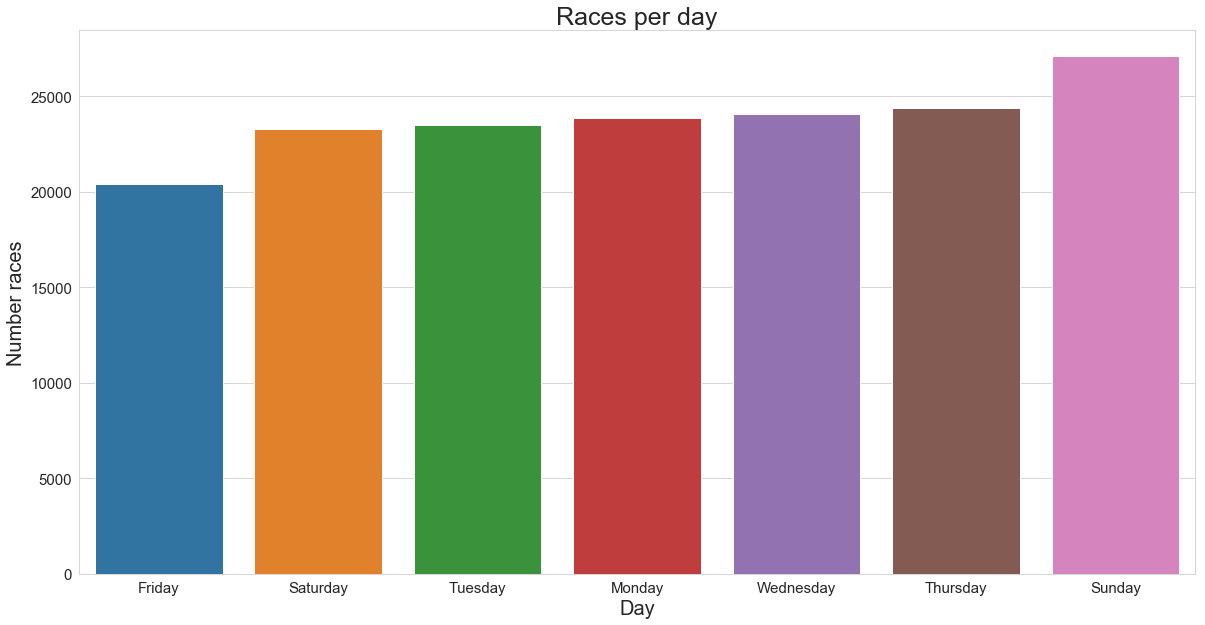

In [16]:
df_time["day"] = df_time["race_created"].dt.strftime("%A")

fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=df_time.groupby("day")["count"].sum().sort_values().index, y=df_time.groupby("day")["count"].sum().sort_values())
plt.title("Races per day", fontsize=title_fontsize)
plt.xlabel("Day", fontsize=axis_fontsize)
plt.ylabel("Number races", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)

plt.show()

## 2 Players
In this part we to investigate the data set with respect to the players.

### 2.1 Consistency
First we check the available data for consistency. More precisely we confirm that no player is able to play him/herself.

In [17]:
print(f"In {len(data.loc[data.opponent==data.challenger])} number of races the player was both challenger and opponent.")

In 0 number of races the player was both challenger and opponent.


### 2.2 Player Ids
Given that the player data is consistent we ask ourself how many players have played the game. For this we first investigate the distribution of player ids:

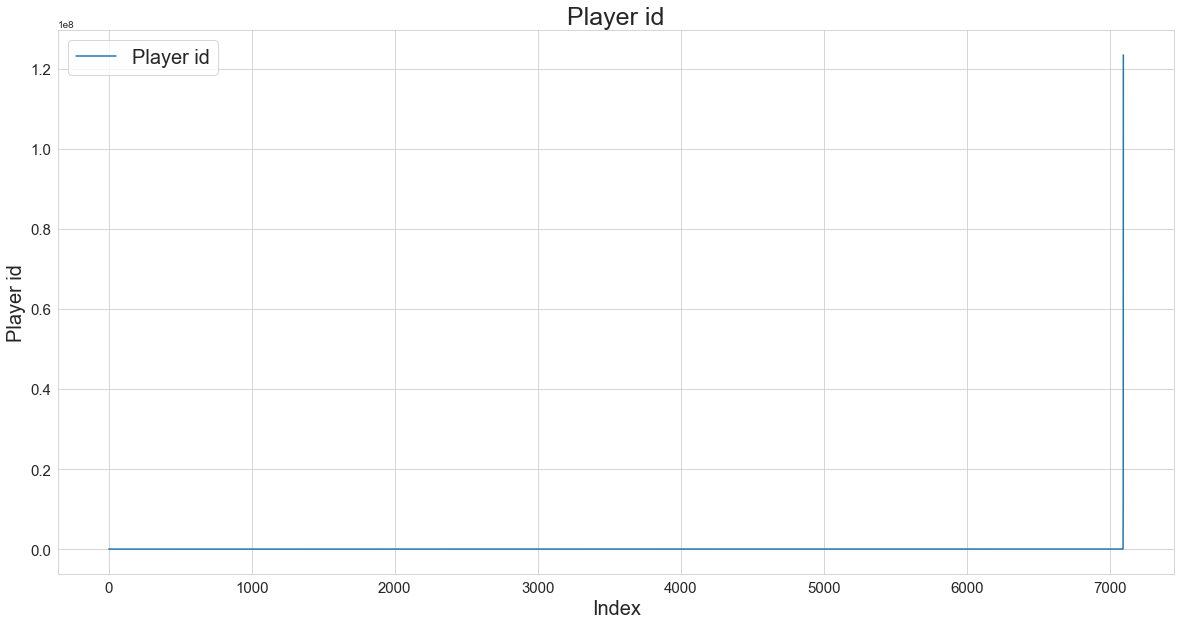

In [18]:
player_ids = list(pd.unique(data[["challenger", "opponent"]].values.ravel("K")))
player_ids.sort()

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(x=range(len(player_ids)), y=player_ids, ax=ax)
plt.title("Player id", fontsize=title_fontsize)
plt.xlabel("Index", fontsize=axis_fontsize)
plt.ylabel("Player id", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(labels = ["Player id"], prop={"size": legend_size})

plt.show()

Apperently there is some strange increase in the player id on the high end of the spectrum. As it turns out in the next cell output TODO LAKSAN DOOF! those ids do not seem to be connected to real players. Partly, because they read "1234567" and furthermore, since noone of the concerned player has actually driven a race.
Thus, we removed said ids from the data set. As a result we obtain a more or less linear relationship between index of players and the player id:

In [19]:
print(f"Strange player ids: {player_ids[-3:]}")
print(f"Race status for strange players: {data.loc[(data.opponent.isin(player_ids[-3:])) | (data.challenger.isin(player_ids[-3:]))].status.unique()}")

Strange player ids: [43000, 12345678, 123456789]
Race status for strange players: ['retired' 'waiting']


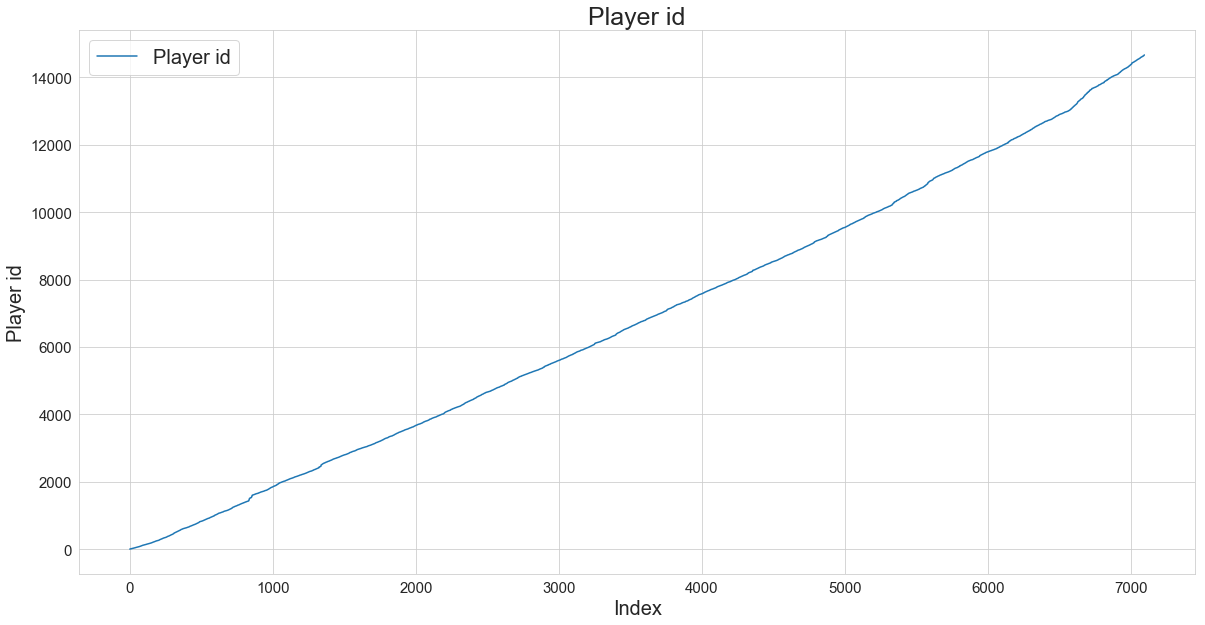

In [20]:
# Remove "fake" players
data.drop(data[data.opponent.isin(player_ids[-3:])].index, inplace=True)

# Plot cleaned distribution
player_ids = list(pd.unique(data[["challenger", "opponent"]].values.ravel("K")))
player_ids.sort()

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(x=range(len(player_ids)), y=player_ids, ax=ax)
plt.title("Player id", fontsize=title_fontsize)
plt.xlabel("Index", fontsize=axis_fontsize)
plt.ylabel("Player id", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(labels = ["Player id"], prop={"size": legend_size})

plt.show()


### 2.3 Multiplayer
The relationship between index and player id is not strictly linear. Thus, we conclude that the game has both a singleplayer and multiplayer modus. As such, we can compute the fraction of players which are only playing single player.

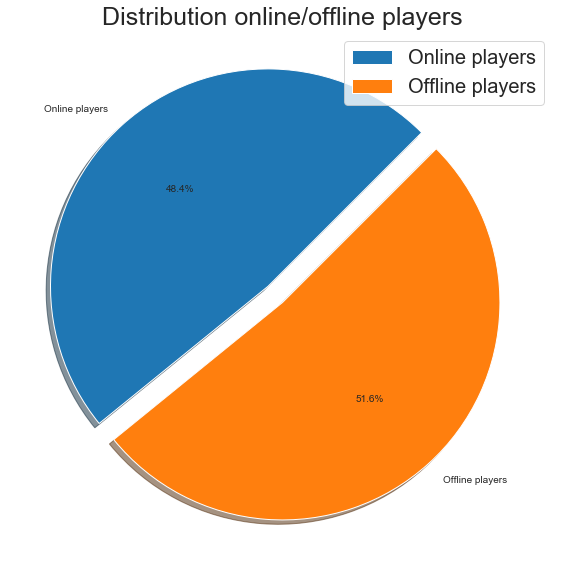

Number of total online players: 7094.
Number of total players: 14669.


In [21]:
df_player = pd.DataFrame(data={"number_online_players": len(player_ids)/player_ids[-1],
                               "number_offline_players": (player_ids[-1]-len(player_ids))/player_ids[-1]}, index=[0]).T
df_player.columns = ["fraction_players"]

fig, ax = plt.subplots(figsize=(10, 10))
df_player.plot.pie(y="fraction_players", explode=[.1, 0], labels=["Online players", "Offline players"], autopct="%1.1f%%",
                        shadow=True, startangle=45, ax=ax)
plt.title("Distribution online/offline players", fontsize=title_fontsize)
ax.legend(prop={"size": legend_size})
ax.set_ylabel("")
plt.show()

print(f"Number of total online players: {len(player_ids)}.\nNumber of total players: {player_ids[-1]}.")

It turns out that the majority of players (51.6%) play the game in single player mode only. It is possible (and likely) that the remaining 48.4% of players also used the singleplayer mode, however, the present data set does not allow for a conclusion in this regard.

### 2.4 Player Activity
Another interesting information is the activity of each player with respect to the amount of driven races. As expected, most players play O(100) races. However, we find a couple of players play a LOT of races. In fact, there is one player (id TODO XY) which played over 20000 races!

In [34]:
# TODO: wie lade ich diese info?

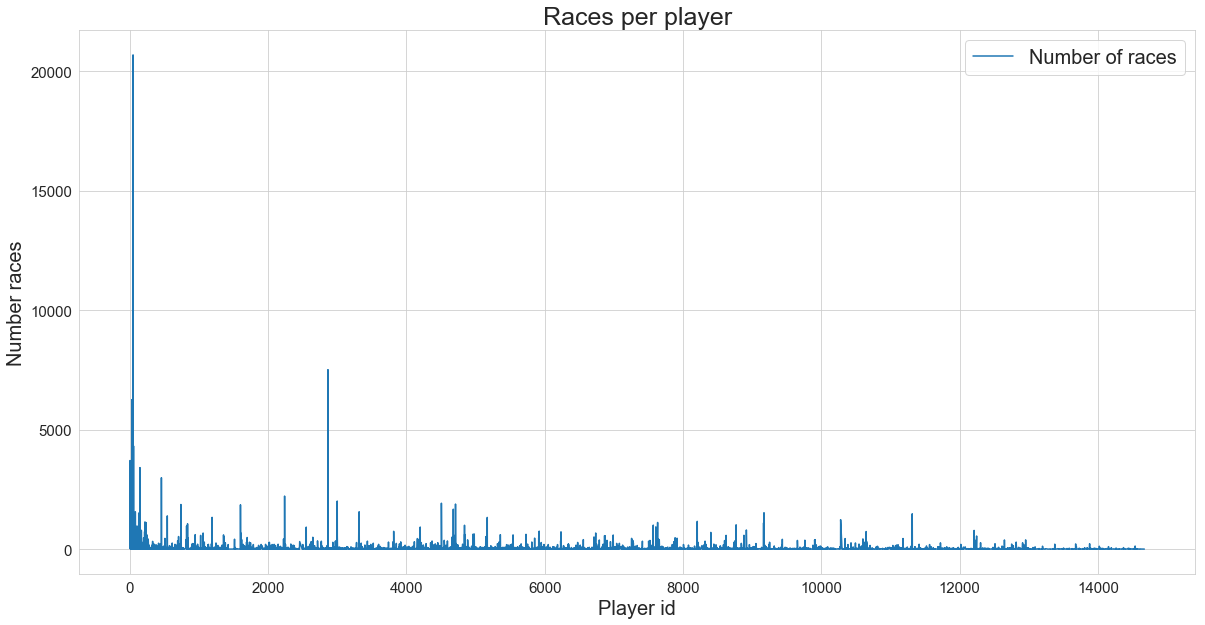

In [22]:
df_player = pd.DataFrame(data.groupby("challenger").count()).reset_index()
df_player.rename(columns={"id": "count", "challenger": "player"}, inplace=True)
df_player = df_player[["player", "count"]]
df_player
df_opponent = pd.DataFrame(data.groupby("opponent").count()).reset_index()
df_opponent.rename(columns={"id": "count", "opponent": "player"}, inplace=True)
df_opponent = df_opponent[["player", "count"]]
df_opponent
df_player = df_player.append(df_opponent).groupby("player").sum()
df_player = df_player.iloc[1:]  # remove player_id=0 since this is a dummy for "no race happened"

fig, ax = plt.subplots(figsize=(20, 10))

df_player.plot(ax=ax)
plt.title("Races per player", fontsize=title_fontsize)
plt.xlabel("Player id", fontsize=axis_fontsize)
plt.ylabel("Number races", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(["Number of races"], prop={"size": legend_size})

plt.show()


### 2.5 Graph Kram

def draw_graph(node_list, title):

    G = nx.DiGraph()
    G.add_edges_from(node_list)

    nx.draw(G,
            cmap=plt.get_cmap('jet'),
            node_color="lightgrey",
            with_labels=True)
    
    plt.title(title)
    plt.show()

graph= data.dropna()

for _ in range(10):
    random_racer = data.challenger.values[randint(0, len(data)-1)]

    random_racer_df = data[(data['challenger'] == random_racer)
                        | (data['opponent'] == random_racer)]

    draw_graph([(a, b) for a, b in zip(random_racer_df.challenger,
                                       random_racer_df.opponent)], "")

In [ ]:
## 3 Race
Next we investigate the time series with respect to the races.

### 3.1 Status
The data set contains over 160000 rows - each representing a single race. A natural question arising is whether all races are actually driven or if some never took place.

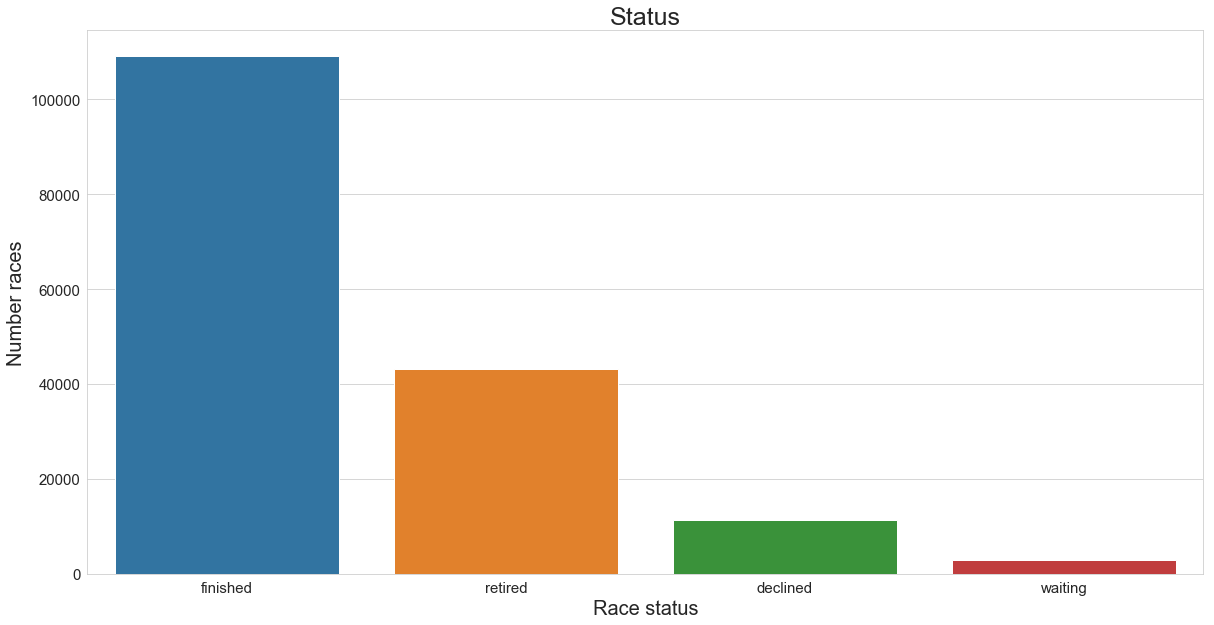

In [36]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=data["status"].value_counts().index, y=data["status"].value_counts().values, ax=ax)
plt.title("Status", fontsize=title_fontsize)
plt.xlabel("Race status", fontsize=axis_fontsize)
plt.ylabel("Number races", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)

plt.show()

Apparently the majority of races are actually driven, however, nearly half of them are canceled, declined, or never occured.

### 3.1 Track
Given that we have 12 different tracks available, we might ask ourselfs if there are any tracks which are more popular than others. This is indeed the case, where track number 12 is the most popular played one with nearly a order of magnitude more races than the second most popular one - track number 3. Given the fact that nearly 50% of the races never took place, we repeat the plot with only actual driven races. We see apporixmately the same distribution, ableit, of course, an overall fewer number of races.

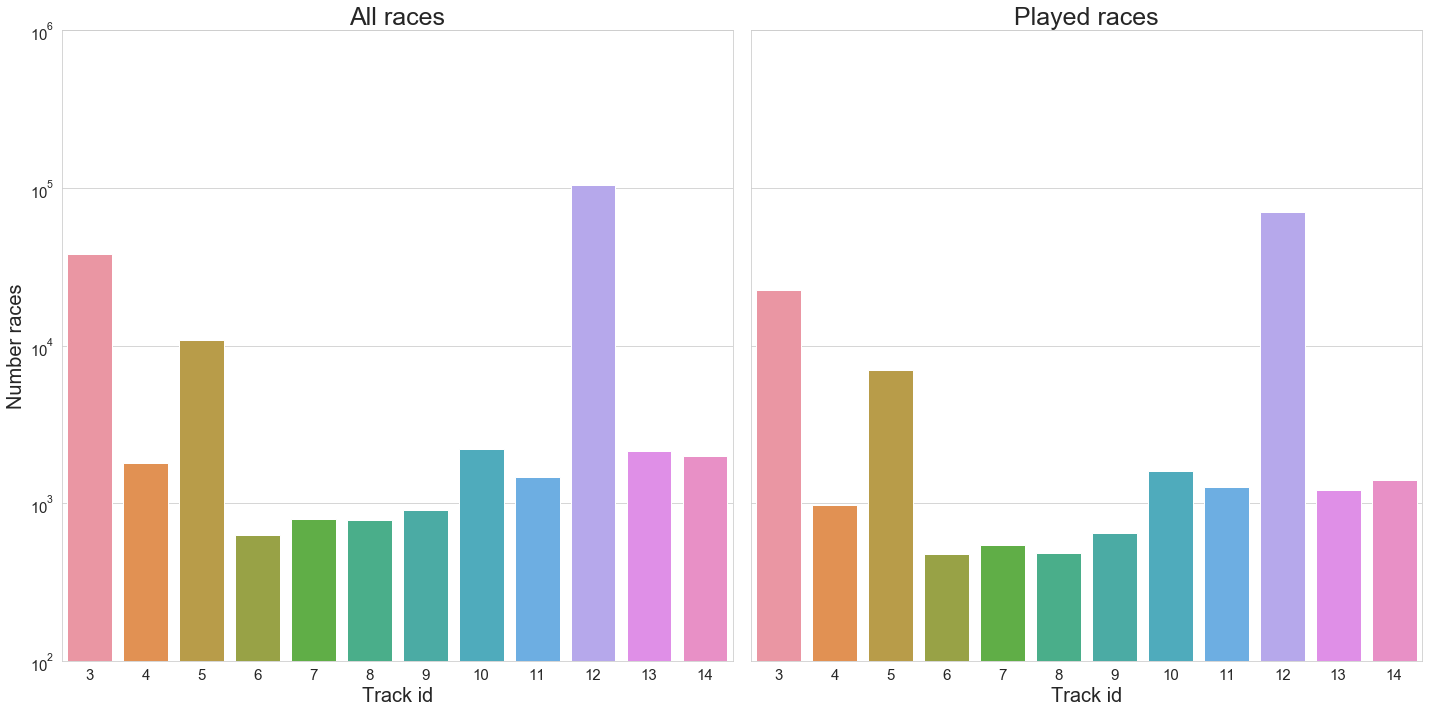

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# All races
sns.barplot(x=data["track_id"].unique(), y=data["track_id"].value_counts(), ax=ax[0])
ax[0].set_title("All races", fontsize=title_fontsize)
ax[0].set_xlabel("Track id", fontsize=axis_fontsize)
ax[0].set_ylabel("Number races", fontsize=axis_fontsize)
ax[0].tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax[0].set_yscale("log")

# Subset of "finished" races
sns.barplot(x=data.loc[data.status=="finished", "track_id"].unique(), y=data.loc[data.status=="finished", "track_id"].value_counts(), ax=ax[1])
ax[1].set_title("Played races", fontsize=title_fontsize)
ax[1].set_xlabel("Track id", fontsize=axis_fontsize)
ax[1].set_ylabel("")
ax[1].tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax[1].set_yscale("log")

plt.setp(ax, ylim=(10**2, 10**6))
fig.tight_layout()
plt.show()

It is strange that track number 1 and 2 are completely missing. This points to either:
- data set is not complete
- those tracks are never used (very unlikely)
- the data might have been (poorly) anonymised

### 3.3 Money
The distribution of money shows a large range from 10 up to several millions. Although, most of the time only a small amount of money was bet.

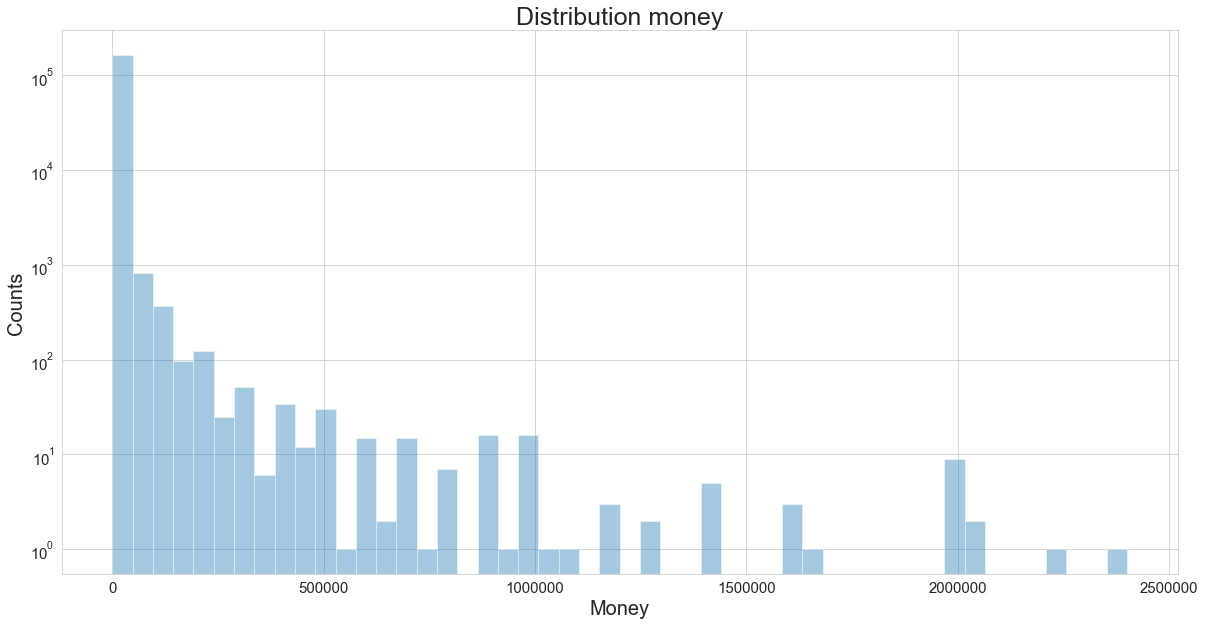

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.distplot(data["money"], kde=False)
plt.title("Distribution money", fontsize=title_fontsize)
plt.xlabel("Money", fontsize=axis_fontsize)
plt.ylabel("Counts", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.set_yscale("log")

plt.show()

### 3.4 Fuel consumption
We notice that the fuel_consumption column of the data frame has the type object. Further analysis reveals that the second most frequent value is given by "Apr 35". This indicates a missinterpretation of the numerical value as a date by MS Excel. We will fix and clean the data in this respect with another script, after completing this basic EDA and come back to fuel consumption when we conduct our advanced EDA.

In [39]:
data["fuel_consumption"].value_counts()

4.425      26589
Apr 35     25523
0.375       6310
0.63        4149
2.529       1506
04. Mai     1149
4.275       1001
02. Apr      930
0.378        845
03. Mrz      844
2.655        807
3.915        802
1.065        774
0.6          720
04. Feb      702
4.215        697
Mrz 54       670
03. Jun      648
0.3975       638
39.225       628
01. Feb      602
0.735        593
3.465        591
Feb 55       584
02. Jul      559
1.335        551
Mrz 81       541
0.825        540
01. Mai      538
Mrz 48       537
           ...  
15.975         1
4.152          1
Aug 57         1
Jun 95         1
1.178          1
27.455         1
5.196          1
7.634          1
4.992          1
3.912          1
44.795         1
1.843          1
2.223          1
3.231          1
5.729          1
4.131          1
4.578          1
0.4905         1
Sep 22         1
Jul 64         1
0.73           1
0.79           1
8.632          1
3.501          1
3.883          1
5.066          1
4.452          1
11.825        

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166597 entries, 0 to 166608
Data columns (total 12 columns):
id                  166597 non-null int64
race_created        166597 non-null datetime64[ns]
race_driven         166597 non-null object
track_id            166597 non-null int64
challenger          166597 non-null int64
opponent            166597 non-null int64
money               166597 non-null int64
fuel_consumption    166597 non-null object
winner              166597 non-null int64
status              166597 non-null object
forecast            166597 non-null object
weather             109095 non-null object
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 16.5+ MB


### 3.5 Weather
Lastly, we play meteorologist and take a look at the weather distribution of the races. Suprisingly the distribution is quite heavily skewed towards nice sunny weather. Even combining rainy, snowy, and thundery weather is still less than the number of races with sunny weather.

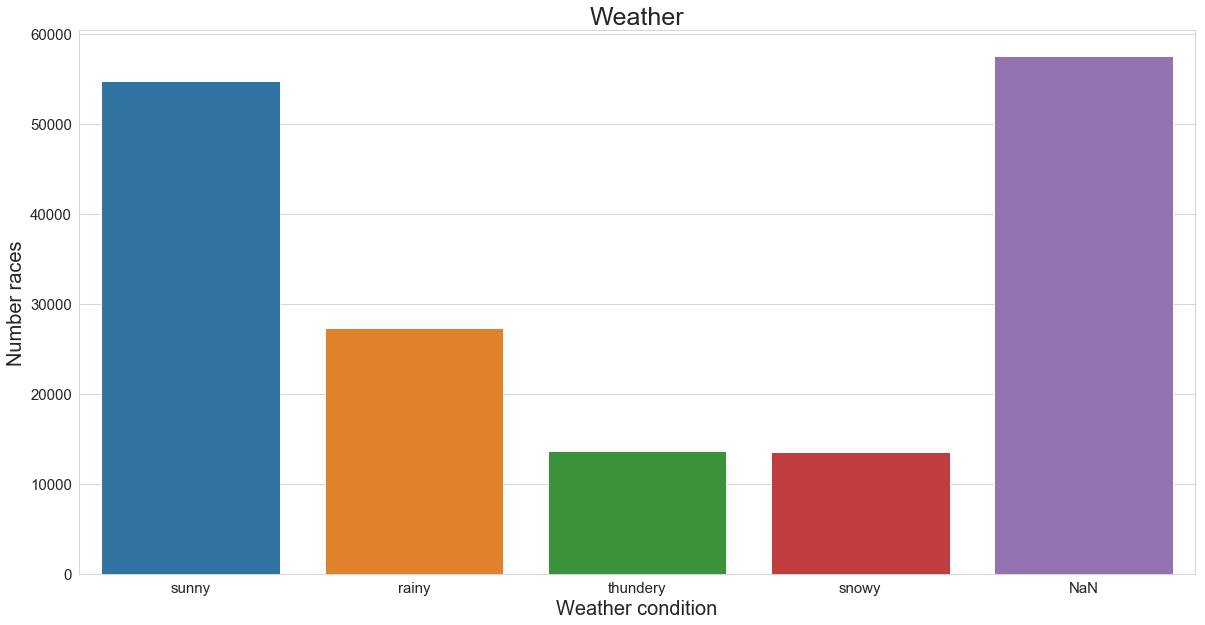

In [41]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=list(data["weather"].value_counts().index) + ["NaN"], y=list(data["weather"].value_counts().values) + [data["weather"].isna().sum()], ax=ax)
plt.title("Weather", fontsize=title_fontsize)
plt.xlabel("Weather condition", fontsize=axis_fontsize)
plt.ylabel("Number races", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)

plt.show()

# SUMMARY
We found that we need to clean the data before we can continue with advanced EDA, feature engineering and with the development and application of ML algorithms. In particular, we have to
- remove unrealistic player ids
- translate the false strings in fuel_consumption back to numerical values
- cast the date columns into international standard format (Year-Month-Day; not necessarily required but makes the handling of the data a little less cumbersum)